In [1]:
import os
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
from ase.data import chemical_symbols
from ase.atoms import Atoms
from ase.calculators import SinglePointCalculator
from ase.visualize import view
from fairchem.core.datasets import LmdbDataset
from fairchem.core.common.relaxation.ase_utils import batch_to_atoms

In [5]:
# i want to save this dataframe to a single csv file

df.write_csv('data/saa_model_predictions/prediction_dataframe.csv')

In [71]:
# I want to load this csv file back into a dataframe
df = pl.read_csv('data/saa_model_predictions/prediction_dataframe.csv')

In [1]:
# I want to compare the "ground_truth_energy" column values with
# the values in the other columns. So I want to create parity plots
# For each column in the dataframe.

# First I will extract the values of the "ground_truth_energy" column into a list
ground_truth = np.array(df['ground_truth_energy'].to_list())

# Now I want to loop through each column that isn't the "ground_truth_energy" column

for column in df.columns:
    if column != 'ground_truth_energy' and column != 'dopant':

        # I will extract the column values into a list
        predicted_energies = np.array(df[column].to_list())
        slope, intercept = np.polyfit(x=ground_truth, y=predicted_energies, deg=1)
        regression_line = slope * ground_truth + intercept
        # I will create a scatter plot of the ground truth values vs the column values
        plt.scatter(ground_truth, regression_line, color='#1f77b4')

        # I want the y-axis label to be horizontal but padded so it doesn't block the axis

        plt.xlabel('Ground Truth Energy')
        plt.ylabel(column, rotation=0, labelpad=40)
        plt.title(f'Parity Plot of {column} vs Ground Truth Energy')

        # want a dashed line at y=x
        # plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], 'k--', lw=2)

        # I only want to plot the end points of the regression line
        plt.plot([min(ground_truth), max(ground_truth)], [min(regression_line), max(regression_line)], color='black', linestyle='--')

        plt.show()

NameError: name 'np' is not defined

In [3]:
df = pl.read_csv('data/saa_model_predictions/prediction_dataframe.csv')

In [4]:
# Columns to exclude
exclude_cols = ["ground_truth_energy", "dopant"]

# Select all columns except the excluded ones
included_cols = df.select(pl.exclude(exclude_cols)).columns

print(df.select(pl.concat_list(included_cols).list.std()))

# Add a new column with the row-wise average and standard deviation
df_with_avg = df.with_columns(
    pl.DataFrame({"prediction_average": df.select(pl.mean_horizontal(included_cols)),
                  "prediction_std": df.select(pl.concat_list(included_cols).list.std())})
)

shape: (22, 1)
┌──────────────┐
│ painn_energy │
│ ---          │
│ f64          │
╞══════════════╡
│ 0.202088     │
│ 0.160861     │
│ 0.176961     │
│ 0.178462     │
│ 0.147144     │
│ …            │
│ 0.16904      │
│ 0.190368     │
│ 0.186852     │
│ 0.171742     │
│ 0.211037     │
└──────────────┘


In [5]:
print(df_with_avg)

shape: (22, 9)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ dopant ┆ ground_tru ┆ painn_ener ┆ scn_energ ┆ … ┆ gemnet_dt ┆ schnet_en ┆ predictio ┆ predictio │
│ ---    ┆ th_energy  ┆ gy         ┆ y         ┆   ┆ _energy   ┆ ergy      ┆ n_average ┆ n_std     │
│ str    ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│        ┆ f64        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Au     ┆ 0.098136   ┆ 0.203165   ┆ 0.262656  ┆ … ┆ 0.363958  ┆ 0.709146  ┆ 0.36258   ┆ 0.202088  │
│ Co     ┆ -0.3403    ┆ -0.19337   ┆ -0.299152 ┆ … ┆ -0.086388 ┆ 0.061191  ┆ -0.169692 ┆ 0.160861  │
│ Cr     ┆ -0.175864  ┆ -0.056166  ┆ -0.196696 ┆ … ┆ 0.055516  ┆ 0.229326  ┆ -0.029422 ┆ 0.176961  │
│ Cu     ┆ -0.067714  ┆ 0.082203   ┆ 0.037689  ┆ … ┆ 0.208947  ┆ 0.473687  ┆

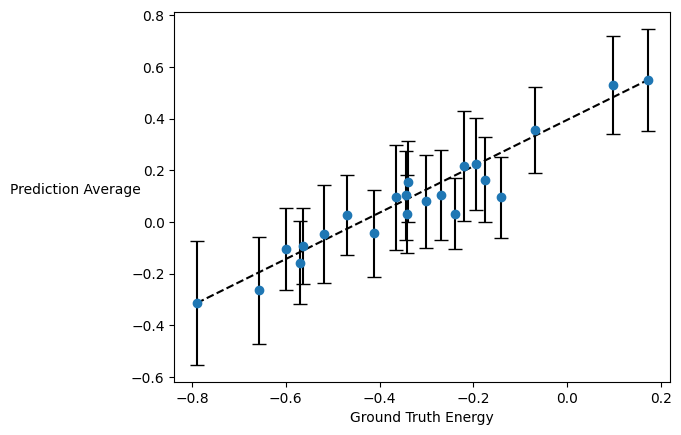

In [24]:
# Using the "ground_truth_energy" column, the "prediction_average" column, and the "prediction_std" column,
# I want to create a parity plot with the "ground_truth_energy" column on the x-axis and the "prediction_average"
# column on the y-axis. I want to create error bars using the "prediction_std" column.

ground_truth = np.array(df_with_avg['ground_truth_energy'].to_list())
std_dev = df_with_avg['prediction_std'].to_list()
average = df_with_avg['prediction_average'].to_list()

slope, intercept = np.polyfit(x=ground_truth, y=average, deg=1)
y_scaled = [slope * y + intercept for y in average]
std_dev_scaled = [sd * slope for sd in std_dev]

plt.errorbar(ground_truth, y_scaled, yerr=std_dev_scaled, fmt='o', color='#1f77b4', ecolor='black', capsize=5)
plt.xlabel('Ground Truth Energy')
plt.ylabel('Prediction Average', rotation=0, labelpad=40)
plt.plot([min(ground_truth), max(ground_truth)], [min(y_scaled), max(y_scaled)], color='black', linestyle='--')

plt.show()


        
        